In [1]:
%load_ext autoreload
%autoreload 2
from src.vnc import run_vnc_simulation


import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from pathlib import Path
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
import jax
# jax.config.update("jax_enable_x64", True)
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"


from src.vnc import *
from src.plot_utils import *

In [2]:
experiment='Stim_Neurons'
with initialize(version_base=None, config_path="../configs"):
    cfg=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)

for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)




experiment='default'
with initialize(version_base=None, config_path="../configs"):
    cfg_old=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg_old)

for k in cfg_old.paths.keys():
    if (k != 'user'):
        cfg_old.paths[k] = Path(cfg_old.paths[k])
        cfg_old.paths[k].mkdir(parents=True, exist_ok=True)


In [3]:
params, config = load_vnc_net(cfg)
# results = simulate_vnc_net(params, config, batch_size=cfg.experiment.batch_size)
# results = process_sequential_minibatches(params, config, batch_size=cfg.experiment.batch_size)
# batch_size = 200

# # Create batches
# tau_batches, n_samples = create_batches(params.tau, batch_size)
# threshold_batches, _ = create_batches(params.threshold, batch_size)
# a_batches, _ = create_batches(params.a, batch_size)
# fr_cap_batches, _ = create_batches(params.fr_cap, batch_size)
# seed_batches, _ = create_batches(params.seeds, batch_size)
# # additional_param_batches, _ = create_batches(additional_param, batch_size)

# # Convert to JAX arrays
# tau_batches = jnp.array(tau_batches)
# threshold_batches = jnp.array(threshold_batches)
# a_batches = jnp.array(a_batches)
# fr_cap_batches = jnp.array(fr_cap_batches)
# seed_batches = jnp.array(seed_batches)
# # additional_param_batches = jnp.array(additional_param_batches)

In [4]:
n_devices = jax.device_count()
n_samples = len(params.tau)
additional_param = jnp.array([0] * n_samples)
batch_size=250
device_batches = create_device_specific_batches(params, additional_param, batch_size, n_devices)

In [16]:
config.t_axis

Array([0.0000000e+00, 1.0000000e-03, 2.0000001e-03, ..., 1.9970001e+00,
       1.9980001e+00, 1.9990001e+00], dtype=float32)

/home/eabe/Research/Github/Pugliese_2025/src/Archive/vnc_old.py:372: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  stim_neurons = jnp.array(cfg.experiment.stimNeurons, dtype=jnp.int64)
/home/eabe/Research/Github/Pugliese_2025/src/Archive/sim_utils_old.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[np.isnan(sizes)] = normSize
/home/eabe/Research/Github/Pugliese_2025/src/Archive/sim_utils_old.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

Setting sizes, normSize: 668150423.0
Setting sizes, NaN indices: (array([], dtype=int64),)


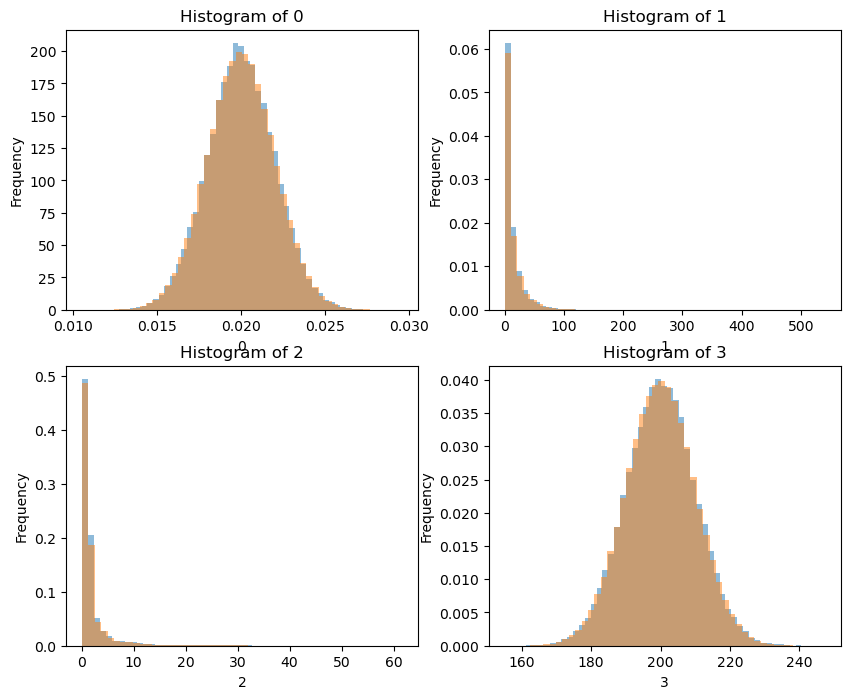

In [54]:
from src.Archive.vnc_old import load_vnc_net as load_vnc_net_old
params, config = load_vnc_net(cfg)
params_old, config_old = load_vnc_net_old(cfg_old)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()
for n, (orig,new) in enumerate(zip([params_old.tau,params_old.threshold,params_old.a,params_old.fr_cap], [params.tau, params.threshold, params.a, params.fr_cap])):
    axs[n].hist(orig.flatten(), bins=50, alpha=0.5, label='Sampled', density=True)
    axs[n].hist(new.flatten(), bins=50, alpha=0.5, label='Original', density=True)
    axs[n].set_title(f"Histogram of {n}")
    axs[n].set_xlabel(n)
    axs[n].set_ylabel("Frequency")

In [ ]:
start_time = time.time()
W_rw = reweight_connectivity(
    params.W, config.exc_synapse_multiplier, config.inh_synapse_multiplier
)

R0 = jnp.zeros((W_rw.shape[1],))

# Determine which run function to use based on configuration
if config.shuffle:
    run_func = run_shuffle
    print("Running simulation with shuffle")
elif config.noise:
    run_func = run_noise
    print("Running simulation with noise")
else:
    run_func = run_no_shuffle
    print("Running simulation without shuffle or noise")

vmap_axes = (
    None,  # W
    None,  # R0
    None,  # tAxis
    None,  # T
    None,  # dt
    None,  # inputs
    None,  # pulseStart
    None,  # pulseEnd
    0,  # tau
    0,  # threshold
    0,  # a
    0,  # frCap
    None,  # seed
    None,  # stdvProp or shuffle indices (depends on function)
    None,  # excDnIdxs
    None,  # inhDnIdxs
    None,  # excInIdxs
    None,  # inhInIdxs
    None,  # mnIdxs
)

# Prepare additional parameter based on simulation type
if config.noise:
    additional_param = config.noise_stdv_prop
else:
    additional_param = None
    
print(jax.make_jaxpr(vmap(run_func, in_axes=vmap_axes))(
    W_rw,
    R0,
    config.t_axis,
    config.T,
    config.dt,
    params.input_currents,
    config.pulse_start,
    config.pulse_end,
    params.tau,
    params.threshold,
    params.a,
    params.fr_cap,
    params.seeds,
    additional_param,
    params.exc_dn_idxs,
    params.inh_dn_idxs,
    params.exc_in_idxs,
    params.inh_in_idxs,
    params.mn_idxs,
))

# Rs = jit(vmap(run_func, in_axes=vmap_axes))(
#     W_rw,
#     R0,
#     config.t_axis,
#     config.T,
#     config.dt,
#     params.input_currents,
#     config.pulse_start,
#     config.pulse_end,
#     params.tau,
#     params.threshold,
#     params.a,
#     params.fr_cap,
#     params.seeds,
#     additional_param,
#     params.exc_dn_idxs,
#     params.inh_dn_idxs,
#     params.exc_in_idxs,
#     params.inh_in_idxs,
#     params.mn_idxs,
# )

end_time = time.time()

print(f"Time to solve system with vmap: {end_time - start_time:.3f} seconds")



In [ ]:
results = run_vnc_simulation(cfg)

Running simulation without shuffle or noise


2025-07-16 20:49:23.344666: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 26.54GiB (28496817440 bytes) by rematerialization; only reduced to 51.04GiB (54804992144 bytes), down from 51.04GiB (54804992144 bytes) originally


In [47]:
np.all(np.sum(results,axis=-1)==0,axis=1).sum()

Array(40, dtype=int32)

0.095705144


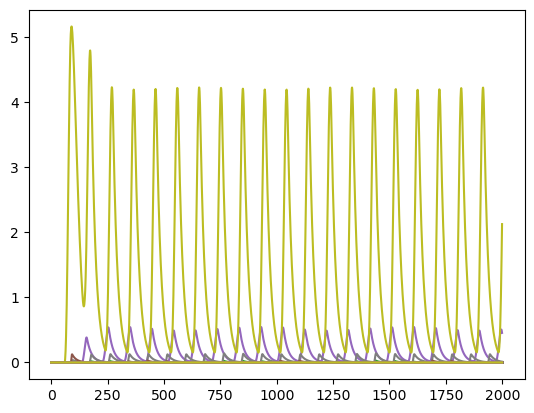

In [ ]:
R = results[6]


wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index


for i in nonMns.index:
# for i in mnIdxs:
    plt.plot(R[i])
    #plt.plot(Rtsp[i])

print(np.mean(R))
